# pix2pix in Tensorflow
The original repo can be found [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md).
Dataset That will be used: [facades](http://cmp.felk.cvut.cz/~tylecr1/facade/)

## preparation
Please download and unzip the [dataset](http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip) into the directory `./dataset/` before running!


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Load images

In [2]:
images = []
labels = []

import glob
from PIL import Image

path = "dataset/base/"

for image_path in glob.glob(path + "*.png"):
    img = Image.open(image_path)
    img = img.resize((200, 200))
    images.append(np.array(img.getdata()).reshape((200, 200)))

    lbl = Image.open(image_path.replace(".png", ".jpg"))
    lbl = lbl.resize((200, 200))
    labels.append(np.array(lbl.getdata()).reshape((200, 200, 3)))

#### Visualization of random images and their labels

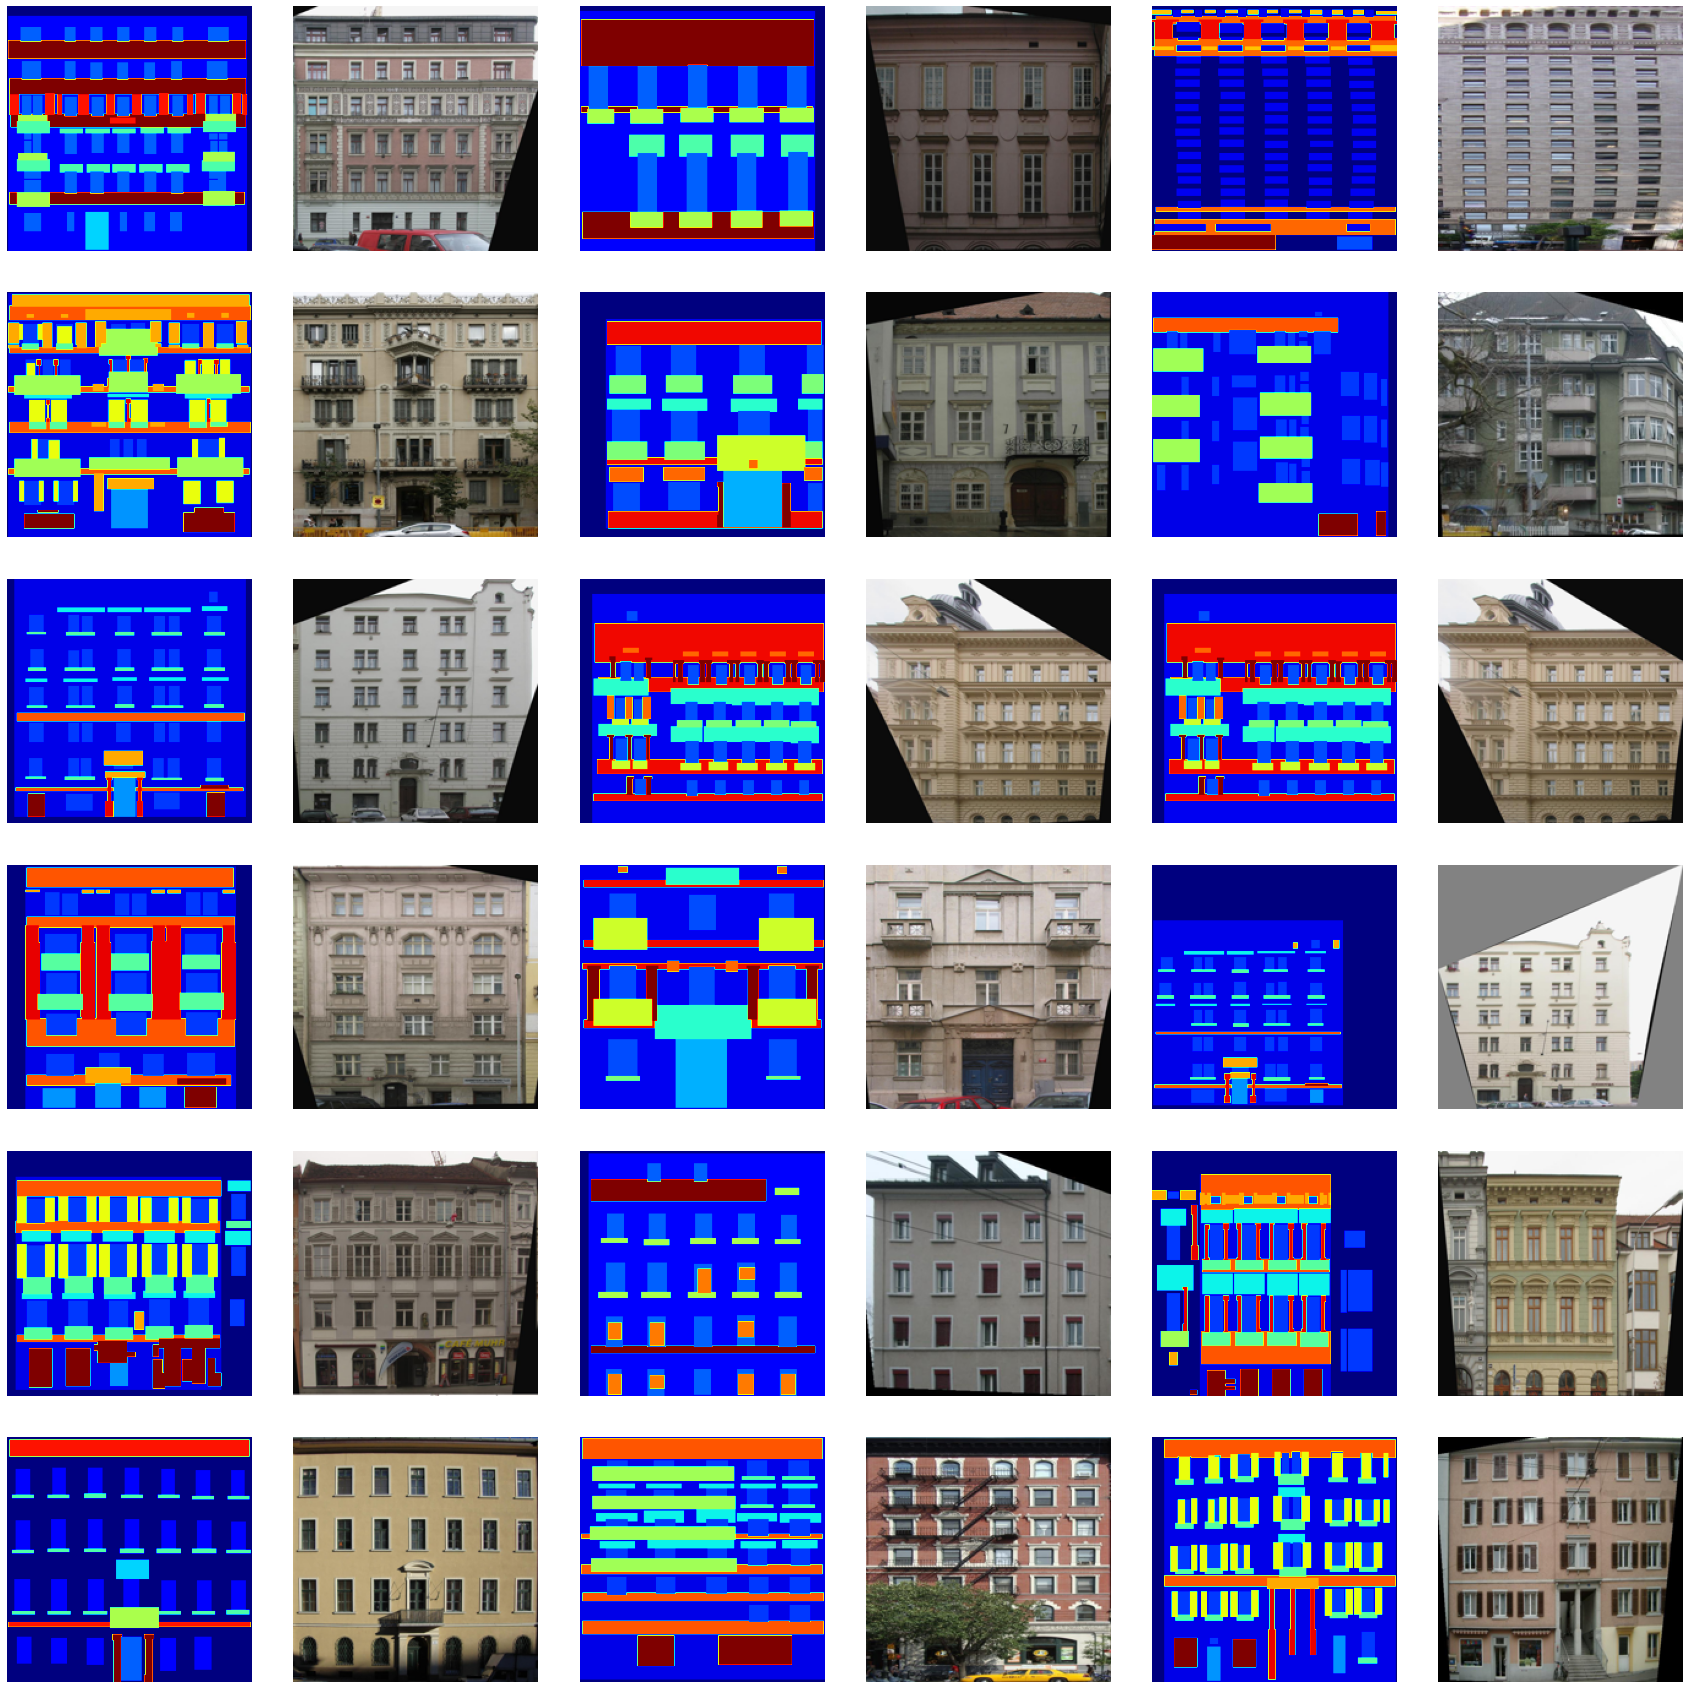

In [3]:
%matplotlib inline
fig, ax = plt.subplots(6,6,figsize=(24,24))
fig.tight_layout()
ax = ax.flatten()
for i in range(18):
    rand = np.random.randint(len(images)-1)
    img = images[rand]
    lbl = labels[rand]
    
    ax[2 * i].imshow(img, cmap='jet')
    ax[2 * i].axis("off")
    ax[2 * i + 1].imshow(lbl)
    ax[2 * i + 1].axis("off")

## Split dataset into train and test

In [4]:
import math
num_test = math.floor(len(images) * 0.1)

test_images = np.array(images[:num_test], dtype=np.float32)
test_labels = np.array(labels[:num_test], dtype=np.float32)

train_images = np.array(images[num_test:], dtype=np.float32)
train_labels = np.array(labels[num_test:], dtype=np.float32)

## Generate tf datasets

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=50000)
batch_size = 64
train_dataset = train_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(10000)

## Define the models

In [6]:
from tensorflow.keras.layers import Layer
import math

### Common layers
The paper defines the following types of Layers:
- C(k)
    - Convolution (k filters; 4x4; stride 2)
    - BatchNorm (in testing and training)
    - ReLU
- CD(k)
    - Convolution (k filters; 4x4; stride 2)
    - BatchNorm (in testing and training)
    - Dropout (50% rate)
    - ReLU

In [31]:
class C(Layer):
    """This layer represents the C(k) layer described in the pix2pix paper. The activation function 
        is a parameter to allow the use of different activation functions like ReLU and leaky ReLU for 
        encoder and decoder. The sampling_factor gives a factor by which the convolution output will be 
        sampled up or down. A value of 2 will sample the tensor up by 2. A value of 0.5 will sample the 
        tensor down by 2."""
        
    def __init__(self, k, activation=None, sampling_factor=None):
        super(C, self).__init__()
        self.conv = tf.keras.layers.Conv2D(k, kernel_size=4, strides=2, activation=None, padding='same')
        
        self.sampling = None
        if sampling_factor != None:
            if sampling_factor > 1:
                self.sampling = tf.keras.layers.UpSampling2D(size=sampling_factor, interpolation='nearest')
            elif sampling_factor < 1:
                self.sampling = tf.keras.layers.MaxPooling1D(pool_size=math.floor(1/sampling_factor), strides=None, padding='valid')
        
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.activation = activation
        
    def call(self, x):
        x = self.conv(x)
        
        if self.sampling != None:
            x = self.sampling(x)
        
        x = self.batchnorm(x)
        
        if self.activation != None:
            x = self.activation(x)
            
        return x

class CD(C):
    """This layer represents the CD(k) layer described in the pix2pix paper. The activation function 
        is a parameter to allow the use of different activation functions like ReLU and leaky ReLU for 
        encoder and decoder. The sampling_factor gives a factor by which the convolution output will be 
        sampled up or down. A value of 2 will sample the tensor up by 2. A value of 0.5 will sample the 
        tensor down by 2."""
    
    def __init__(self, k, activation=None, sampling_factor=None):
        super(CD, self).__init__(k, activation, sampling_factor)
        self.drouput = tf.keras.layers.Dropout(rate=0.5)
    
    def call(self, x):
        x = self.conv(x)
        
        if self.sampling != None:
            x = self.sampling(x)
        
        x = self.batchnorm(x)
        
        x = self.dropout(x)
        
        if self.activation != None:
            x = self.activation(x)
            
        return x

### Define the discriminator
**16 x 16:**
- C64
- C128 
- conv to 1d
- sigmoid

**70 x 70:**
- C64 
- C128 
- C256 
- C512 
- conv to 1d 
- sigmoid
    
**286 x 286:**
- C64 
- C128 
- C256 
- C512 
- C512
- C512 
- conv to 1d 
- sigmoid

In [34]:
# 16 x 16 discriminator:
class Discriminator16(Layer):
    def __init__(self):
        super(Discriminator16, self).__init__()
        self.conv1 = C(k=64, activation=tf.keras.activations.relu, sampling_factor=0.5)
        self.conv2 = C(k=128, activation=tf.keras.activations.relu, sampling_factor=0.5)
        
        # flatten and dense with one neuron and sigmoid is the same as conv to 1D and sigmoid
        self.flatten = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.out(x)
        return x

### Define the Generator model

For testing purposes first of all a simple encoder decoder model:

encoder: (Leaky ReLU (slope = 0.2))
- C64
- C128
- C256
- C512
- C512
- C512
- C512
- C512

decoder: (ReLU)
- CD512
- CD512
- CD512
- CD512
- C256
- C128
- C64
- reduction to output channels
- tanh

In [36]:
class Generator(Layer):
    def __init__(self):
        super(Generator, self).__init__()
        
        # encoder:
        self.enc_conv1 = C(k=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2), sampling_factor=0.5)
        self.enc_conv2 = C(k=128, activation=tf.keras.activations.LeakyReLU(alpha=0.2), sampling_factor=0.5)
        self.enc_conv3 = C(k=256, activation=tf.keras.activations.LeakyReLU(alpha=0.2), sampling_factor=0.5)
        self.enc_conv4 = C(k=512, activation=tf.keras.activations.LeakyReLU(alpha=0.2), sampling_factor=0.5)
        self.enc_conv5 = C(k=512, activation=tf.keras.activations.LeakyReLU(alpha=0.2), sampling_factor=0.5)
        self.enc_conv6 = C(k=512, activation=tf.keras.activations.LeakyReLU(alpha=0.2), sampling_factor=0.5)
        self.enc_conv7 = C(k=512, activation=tf.keras.activations.LeakyReLU(alpha=0.2), sampling_factor=0.5)
        self.enc_conv8 = C(k=512, activation=tf.keras.activations.LeakyReLU(alpha=0.2), sampling_factor=0.5)
        
        # decoder
        self.dec_conv1 = CD(k=512, activation=tf.keras.activations.relu, sampling_factor=2)
        self.dec_conv2 = CD(k=512, activation=tf.keras.activations.relu, sampling_factor=2)
        self.dec_conv3 = CD(k=512, activation=tf.keras.activations.relu, sampling_factor=2)
        self.dec_conv4 = CD(k=512, activation=tf.keras.activations.relu, sampling_factor=2)
        self.dec_conv5 = C(k=256, activation=tf.keras.activations.relu, sampling_factor=2)
        self.dec_conv6 = C(k=128, activation=tf.keras.activations.relu, sampling_factor=2)
        self.dec_conv7 = C(k=64, activation=tf.keras.activations.relu, sampling_factor=2)
        
        self.out = tf.keras.layers.Conv2D(3, kernel_size=3, strides=1, activation=tf.keras.activations.tanh, padding='same')
        
    def call(self, x):
        x = self.enc_conv1(x)
        x = self.enc_conv2(x)
        x = self.enc_conv3(x)
        x = self.enc_conv4(x)
        x = self.enc_conv5(x)
        x = self.enc_conv6(x)
        x = self.enc_conv7(x)
        x = self.enc_conv8(x)
        
        x = self.dec_conv1(x)
        x = self.dec_conv2(x)
        x = self.dec_conv3(x)
        x = self.dec_conv4(x)
        x = self.dec_conv5(x)
        x = self.dec_conv6(x)
        x = self.dec_conv7(x)
        
        x = self.out(x)
        return x
model = Generator()

AttributeError: module 'tensorflow.keras.activations' has no attribute 'LeakyReLU'

## Train the networks
As described in the paper, we fist optimize the discriminator